In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

#import autokeras as ak
import matplotlib.pyplot as plt

import os
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimage

from sklearn.model_selection import train_test_split

%matplotlib inline

from keras.models import load_model
from keras.models import  Model
from keras.layers import Input, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
df = pd.read_csv("train.csv")
df['has_cactus'] = df['has_cactus'].astype('bool').astype('str')

In [3]:
df.has_cactus.value_counts()

True     13136
False     4364
Name: has_cactus, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null object
dtypes: object(2)
memory usage: 273.5+ KB


In [5]:
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,True
1,000c8a36845c0208e833c79c1bffedd1.jpg,True
2,000d1e9a533f62e55c289303b072733d.jpg,True
3,0011485b40695e9138e92d0b3fb55128.jpg,True
4,0014d7a11e90b62848904c1418fc8cf2.jpg,True


In [6]:
df_train, df_test = train_test_split(df)

In [7]:
df_truth = pd.read_csv("almost_truth.csv")
df_truth['has_cactus'] = (df_truth['has_cactus'] > 0.5).astype('int').astype('bool').astype('str')

In [8]:
df_truth.has_cactus.value_counts()

True     3106
False     894
Name: has_cactus, dtype: int64

In [9]:
df_truth.head()

,id,has_cactus
0,79ac4cc3b082e0a1defe1be601806efd.jpg,True
1,e880364d6521c6f3a27748ec62b0e335.jpg,True
2,74912492b6cdf28c4bfb9c8e1d35af3e.jpg,True
3,078cfa961183b30693ea2f13f5ff6d17.jpg,True
4,7fd729184ef182899ce3e7a174fb9bc0.jpg,True


In [10]:
df_train.has_cactus.value_counts()

True     9842
False    3283
Name: has_cactus, dtype: int64

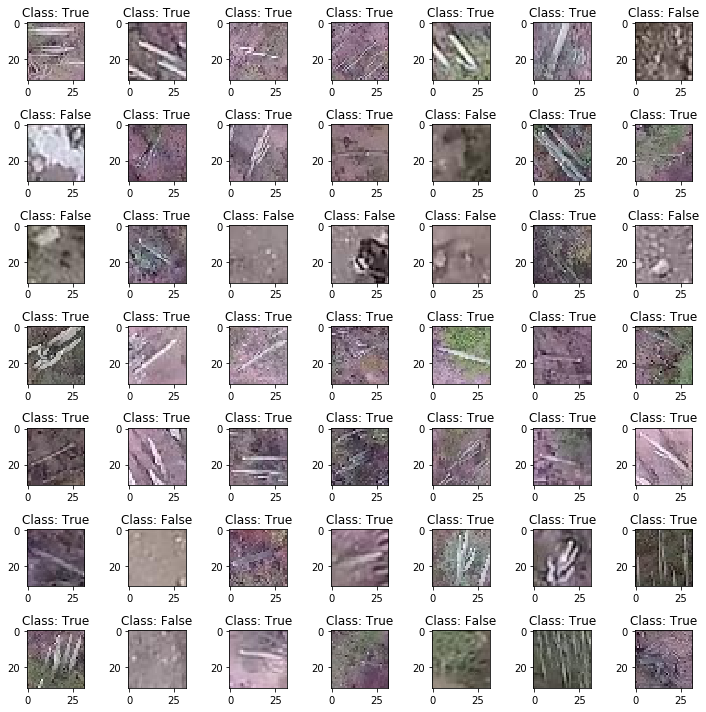

In [11]:
def plot_images_df(df, top=25):
  
  plt.figure(figsize=(10, 10))
  for idx in range(top):
    pics_per_row = int(top**.5)
    plt.subplot(pics_per_row, pics_per_row, idx + 1)

    img = mpimage.imread(os.path.join('train', df.iloc[idx].id))
    plt.imshow(img)
    plt.title('Class: {}'.format(df.iloc[idx].has_cactus))

  plt.tight_layout()

plot_images_df(df, 49)

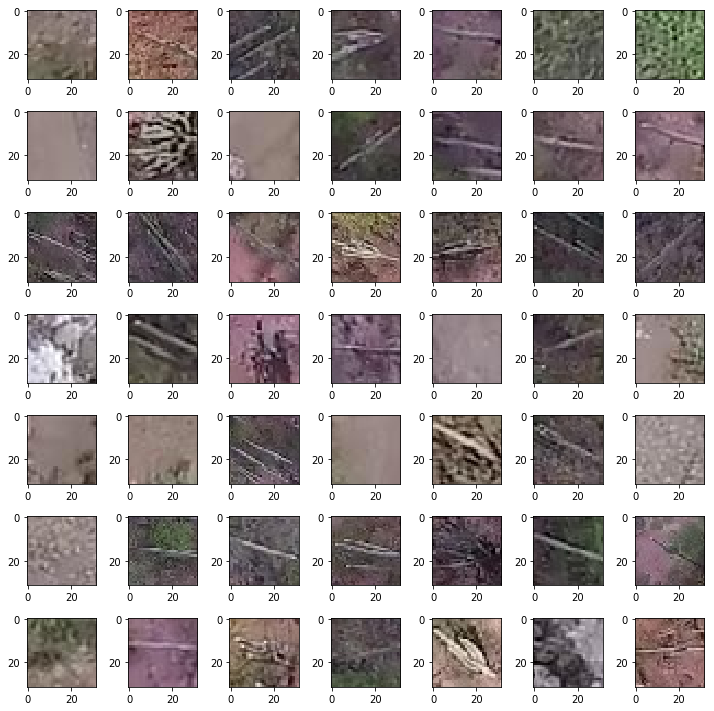

In [12]:
def plot_images(item_dir, top=25):
  
  all_items_dir = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_items_dir][:top]

  plt.figure(figsize=(10, 10))
  for idx, img_path in enumerate(item_files):
    pics_per_row = int(top**.5)
    plt.subplot(pics_per_row, pics_per_row, idx + 1)

    img = mpimage.imread(img_path)
    plt.imshow(img)

  plt.tight_layout()

plot_images("test", 49)

In [14]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict_proba(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        y_pred_val = self.model.predict_proba(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [13]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(dataframe=df, directory="train", x_col="id", y_col="has_cactus", class_mode="binary", target_size=(32,32), batch_size=175, shuffle=False)
#train_generator = datagen.flow_from_dataframe(dataframe=df_train, directory="train", x_col="id", y_col="has_cactus", class_mode="binary", target_size=(32,32), batch_size=32)
#validation_generator = datagen.flow_from_dataframe(dataframe=df_test, directory="train", x_col="id", y_col="has_cactus", class_mode="binary", target_size=(32,32), batch_size=32)

Found 17500 images belonging to 2 classes.


In [14]:
input_shape = (32, 32, 3)

model = Sequential([
    Conv2D(64, (3,3), input_shape=input_shape),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3,3)),
    MaxPool2D((2, 2)),
    
    Conv2D(256, (3,3)),
    MaxPool2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')    
])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxP

In [15]:
history = model.fit_generator(
  train_generator,
  #validation_data=validation_generator,
  steps_per_epoch=100,
  epochs=15,
  validation_steps=50,
  verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 13s - loss: 0.2519 - acc: 0.7494
Epoch 2/15
 - 17s - loss: 0.2494 - acc: 0.7506
Epoch 3/15
 - 27s - loss: 0.2494 - acc: 0.7506
Epoch 4/15
 - 25s - loss: 0.2494 - acc: 0.7506
Epoch 5/15
 - 21s - loss: 0.2494 - acc: 0.7506
Epoch 6/15
 - 19s - loss: 0.2494 - acc: 0.7506
Epoch 7/15
 - 21s - loss: 0.2494 - acc: 0.7506
Epoch 8/15
 - 17s - loss: 0.2494 - acc: 0.7506
Epoch 9/15
 - 18s - loss: 0.2494 - acc: 0.7506
Epoch 10/15
 - 19s - loss: 0.2494 - acc: 0.7506
Epoch 11/15
 - 17s - loss: 0.2494 - acc: 0.7506
Epoch 12/15
 - 20s - loss: 0.2494 - acc: 0.7506
Epoch 13/15
 - 17s - loss: 0.2494 - acc: 0.7506
Epoch 14/15
 - 18s - loss: 0.2494 - acc: 0.7506
Epoch 15/15
 - 16s - loss: 0.2494 - acc: 0.7506


In [18]:
#from autokeras.image.image_supervised import load_image_dataset

#Xak, yak = load_image_dataset(csv_file_path="train_ak.csv",
#                                      images_path="train")
#print(Xak.shape)
#model_ak = ak.ImageRegressor(verbose=True)
#model_ak.fit(Xak, yak, time_limit=30*60)

In [16]:
model.evaluate_generator(train_generator, steps=20)

[0.25485714301466944, 0.7451428592205047]

In [20]:
#model.evaluate_generator(validation_generator, steps=df_test.shape[0])

In [21]:
#model.evaluate_generator(truth_generator, steps=df_truth.shape[0])

In [17]:
df_test_final = pd.DataFrame({"id": os.listdir("test")})
truth_generator = datagen.flow_from_dataframe(dataframe=df_truth, directory="test", x_col="id", y_col="has_cactus", class_mode="binary", target_size=(32,32), batch_size=200, shuffle=False)
#drop_duplicates=True, seed=2019, pickle_safe = True, workers=1
df_test_final['has_cactus'] = model.predict_generator(truth_generator, steps=20)
#df_test_final.to_csv('lkoziol_prediction.csv', index=False)
df_test_final['has_cactus'] = (df_test_final['has_cactus'] > .5).astype('int').astype('bool').astype('str')
#df_test_final.head()
dfs = pd.merge(df_test_final, df_truth, on='id')
diff = (dfs['has_cactus_x'] == dfs['has_cactus_y']).astype('int')
sum(diff.astype('int'))/len(dfs)

Found 4000 images belonging to 2 classes.


0.7765

In [18]:
model.evaluate_generator(truth_generator, steps=20)

[0.22349999770522117, 0.7764999955892563]

In [19]:
post_df_train = pd.read_csv("train.csv")
post_df_train['has_cactus'] = post_df_train['has_cactus'].astype('bool').astype('str')
post_train_generator = datagen.flow_from_dataframe(dataframe=post_df_train, directory="train", x_col="id", y_col="has_cactus", class_mode="binary", target_size=(32,32), batch_size=175)

preds = model.predict_generator(post_train_generator, steps=100) 
post_df_train['has_cactus'] = preds
post_df_train['has_cactus'] = (post_df_train['has_cactus'] >= .5).astype('int').astype('bool').astype('str')

dfs = pd.merge(post_df_train, df_train, on='id')
diff = (dfs['has_cactus_x'] == dfs['has_cactus_y']).astype('int')
sum(diff.astype('int'))/len(dfs)

Found 17500 images belonging to 2 classes.


0.7498666666666667

In [25]:
# mae/sgd -> .75/ .22 .77
# mae/adam -> .75/ .22 .78
# mae/rmsprop -> .75/ .22 .78